# Importing libraries

In [1]:
# this module provides functions for interacting with the operating system 
import os
import pickle
import sys

# it's used for mathematical operations on large, multi-dimensional arrays and matrices
import numpy as np

# Pandas used for data manipulation and analysis
import pandas as pd

# data visualization library for 2D and 3D plots, built on numpy
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn is based on matplotlib; used for plotting statistical graphics
import seaborn as sns

# plotting
import plotly.express as px

# sklearn helpful ML libraries including clasifiers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
import time

# to suppress warnings
import warnings
warnings.filterwarnings("ignore") 

# Importing Data and removing useless columns, splitting data exfiltration

In [2]:
train_path = "https://cloudstor.aarnet.edu.au/plus/s/umT99TnxvbpkkoE/download?path=%2FCSV%2FTraning%20and%20Testing%20Tets%20(5%25%20of%20the%20entier%20dataset)%2F10-best%20features%2F10-best%20Training-Testing%20split&files=UNSW_2018_IoT_Botnet_Final_10_best_Training.csv"
test_path = "https://cloudstor.aarnet.edu.au/plus/s/umT99TnxvbpkkoE/download?path=%2FCSV%2FTraning%20and%20Testing%20Tets%20(5%25%20of%20the%20entier%20dataset)%2F10-best%20features%2F10-best%20Training-Testing%20split&files=UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [3]:
#ARP packets were excluded because they are used to convert an IP address to a MAC address and irrelevant to the proposed attacks in the dataset
train_data = train_data[train_data.proto!="arp"]
test_data = test_data[test_data.proto!="arp"]

#dropping unused columns
train_data.drop(['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport',"attack","category"],axis=1,inplace=True)
test_data.drop(['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport',"attack","category"],axis=1,inplace=True)
full_data = pd.concat([train_data,test_data],axis=0)

In [4]:
data_exf = train_data.loc[train_data.subcategory=="Data_Exfiltration"].sample(n=2,random_state=42)
test_data=test_data.append([data_exf])
train_data=train_data.drop(data_exf.index)

In [5]:
# Place the class in the begining of the dataframe
class_train = train_data['subcategory']
train_data.drop(['subcategory'], axis=1, inplace=True)
train_data.insert(0, 'subcategory', class_train)

class_test = test_data['subcategory']
test_data.drop(['subcategory'], axis=1, inplace=True)
test_data.insert(0, 'subcategory', class_test)

class_full = full_data['subcategory']
full_data.drop(['subcategory'], axis=1, inplace=True)
full_data.insert(0, 'subcategory', class_full)

# Checking Balance of the Data

In [6]:
test_data.subcategory.value_counts()

UDP                  396568
TCP                  318332
Service_Scan          14530
OS_Fingerprint         3615
HTTP                    502
Normal                   98
Keylogging               13
Data_Exfiltration         2
Name: subcategory, dtype: int64

In [7]:
train_data.subcategory.value_counts()

UDP                  1584622
TCP                  1274811
Service_Scan           58592
OS_Fingerprint         14267
HTTP                    1965
Normal                   332
Keylogging                57
Data_Exfiltration          3
Name: subcategory, dtype: int64

In [8]:
d = full_data.subcategory.value_counts()
fig = px.bar(d, x=d.index, y=d.values,title = 'Class distribution between attack subcategories on full data',labels = {'index':'Attack','y':'Volume'},color=d.values)
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

# Checking Missing Data and datatypes

In [9]:
percent_missing = train_data.isnull().sum() * 100 / len(train_data)
missing_values = pd.DataFrame({'% missing': percent_missing})
missing_values.sort_values(by ='% missing' , ascending=False)

,% missing
subcategory,0.0
seq,0.0
stddev,0.0
N_IN_Conn_P_SrcIP,0.0
min,0.0
state_number,0.0
mean,0.0
N_IN_Conn_P_DstIP,0.0
drate,0.0
srate,0.0


In [10]:
pd.DataFrame({'Data Type': full_data.dtypes})

,Data Type
subcategory,object
seq,int64
stddev,float64
N_IN_Conn_P_SrcIP,int64
min,float64
state_number,int64
mean,float64
N_IN_Conn_P_DstIP,int64
drate,float64
srate,float64


# Undersampling

In [11]:
d = full_data.subcategory.value_counts()
fig = px.bar(d, x=d.index, y=d.values,title = 'Class Label Distribution in Bot-IoT',labels = {'index':'Attack','y':'Volume'},color=d.values,text_auto='.2s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

In [12]:
shuffled_df = full_data.sample(frac=1,random_state=4)

nontcpudp_df = shuffled_df.loc[(shuffled_df['subcategory'] != "UDP") & (shuffled_df['subcategory'] != "TCP")]

udp_df = shuffled_df.loc[shuffled_df['subcategory'] == "UDP"].sample(n=73122,random_state=42)
tcp_df = shuffled_df.loc[shuffled_df['subcategory'] == "TCP"].sample(n=73122,random_state=42)

normalized_full_df = pd.concat([nontcpudp_df, udp_df, tcp_df])

#TRAIN after undersampling
d = normalized_full_df.subcategory.value_counts()
fig = px.bar(d, x=d.index, y=d.values,title = 'Class Label Distribution in Bot-IoT (undersampled)',labels = {'index':'Attack','y':'Volume'},color=d.values,text_auto='.2s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

# Binary Classification

In [13]:
normalized_full_df['subcategory'] = (normalized_full_df['subcategory'] != 'Normal').astype(int)

# Splitting into Train and Test datasets

In [14]:
normalized_full_df.subcategory.value_counts()

1    239790
0       430
Name: subcategory, dtype: int64

In [15]:
normalized_full_df.head()

,subcategory,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max
1285197,1,20019,0.0,30,0.241459,6,0.241459,100,16.56596,20.707449,0.241459
700970,1,19119,0.0,42,0.000000,5,0.000000,10,0.00000,0.000000,0.000000
506761,1,7147,0.0,44,0.003381,1,0.003381,100,0.00000,0.000000,0.003381
512201,1,28496,0.0,100,0.004111,1,0.004111,100,0.00000,0.000000,0.004111
95683,1,5836,0.0,100,0.000807,1,0.000807,100,0.00000,0.000000,0.000807


In [16]:
X = normalized_full_df.drop(["subcategory"], axis = 1)
##dropping features
# X.drop(['state_number'],axis=1,inplace=True)

Y = normalized_full_df['subcategory']

X = pd.get_dummies(X, prefix_sep='_')
# le = LabelEncoder()
# Y2 = le.fit_transform(Y)
X2 = StandardScaler().fit_transform(X)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X2, Y, test_size = 0.2, random_state = 9)

In [17]:
print(X_Train.shape,X_Test.shape)

(192176, 10) (48044, 10)


In [18]:
print(Y_Train.shape,Y_Test.shape)

(192176,) (48044,)


In [19]:
print(Counter(Y_Test))
print(Counter(Y_Train))

Counter({1: 47948, 0: 96})
Counter({1: 191842, 0: 334})


In [20]:
d = pd.Series(data=Counter(Y_Train).values(), index = Counter(Y_Train).keys())
fig = px.bar(d, x=d.index, y=d.values,title = 'Class Label Distribution in Bot-IoT - Training',labels = {'x':'Attack','y':'Volume'},color=d.values,text_auto='.3s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

# Oversampling

In [21]:
%%time

sm = SMOTE(random_state=42,sampling_strategy='auto') #k_neighbors=3
X_Smote_Train, Y_Smote_Train = sm.fit_resample(X_Train, Y_Train)
oversampled_train = pd.concat([pd.DataFrame(Y_Smote_Train), pd.DataFrame(X_Smote_Train)], axis=1)
oversampled_train.columns = normalized_full_df.columns

CPU times: user 118 ms, sys: 4.91 ms, total: 122 ms
Wall time: 132 ms


In [22]:
print(f"Before: {Counter(Y_Train)}, number of records: {sum(Counter(Y_Train).values())}")
print(f"After: {Counter(Y_Smote_Train)}, number of records: {sum(Counter(Y_Smote_Train).values())}")

Before: Counter({1: 191842, 0: 334}), number of records: 192176
After: Counter({1: 191842, 0: 191842}), number of records: 383684


In [23]:
d = oversampled_train.subcategory.value_counts()
fig = px.bar(d, x=d.index, y=d.values,title = 'Class Label Distribution in Bot-IoT (oversampled with SMOTE)',labels = {'x':'Attack','y':'Volume'},color=d.values,text_auto='.2s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

# Feature Correlation

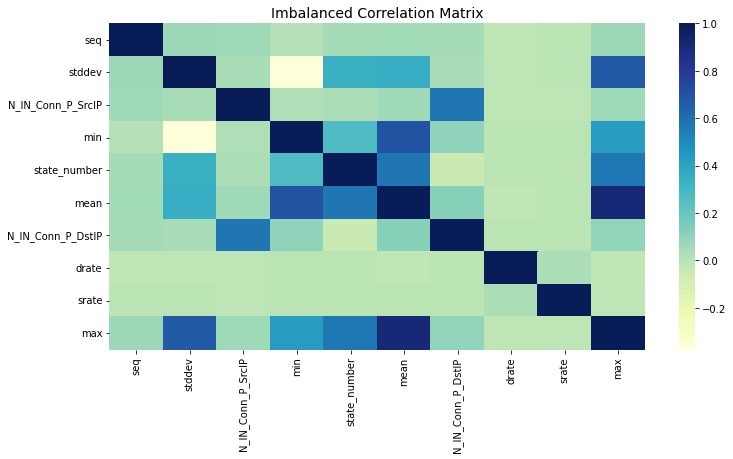

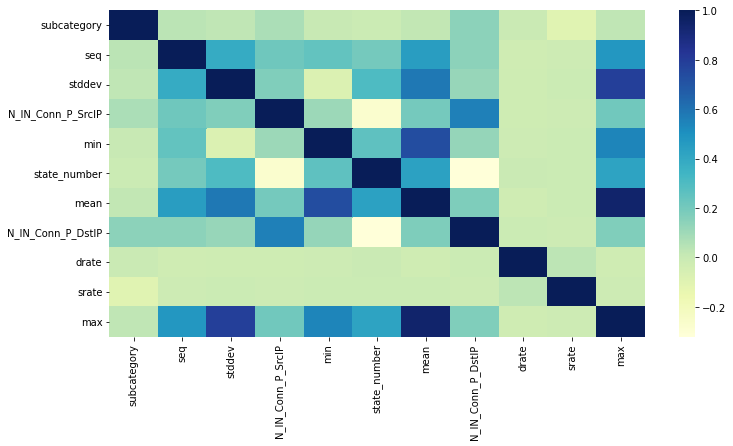

In [24]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(12,6))        
fig, ax1 = plt.subplots(figsize=(12,6))    

# Imbalanced DataFrame Correlation
corr = full_data.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

# Imbalanced DataFrame Correlation
corr2 = normalized_full_df.corr()
sns.heatmap(corr2, cmap='YlGnBu', annot_kws={'size':30}, ax=ax1)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

# Random Forests

In [25]:
%%time

rfc = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_Train,Y_Train) #SMOTE: X_Smote_Train,Y_Smote_Train
prediction_forest = rfc.predict(X_Test)
print(classification_report(Y_Test,prediction_forest))
print(f"Accuracy: {rfc.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(rfc))} bytes")

cm_forest = confusion_matrix(Y_Test, prediction_forest, labels=[1,0])
print(cm_forest)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        96
           1       1.00      1.00      1.00     47948

    accuracy                           1.00     48044
   macro avg       0.99      0.99      0.99     48044
weighted avg       1.00      1.00      1.00     48044

Accuracy: 0.9999375572391974
Model size: 99896 bytes
[[47946     2]
 [    1    95]]
CPU times: user 3.05 s, sys: 15 ms, total: 3.06 s
Wall time: 3.57 s


## Feature Importance using RF

In [26]:
feat_importances = pd.Series(rfc.feature_importances_, index= X.columns).sort_values(ascending=False)
fig = px.bar(d, x=feat_importances.index, y=feat_importances.values,title = 'Feature Importance using RF',labels = {'x':'Feature','y':'Importance'},color=feat_importances.values,text_auto=False)
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

# Gradient Boosting

In [27]:
%%time

gb = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,max_depth=1, random_state=42).fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train
prediction_gb = gb.predict(X_Test)
print(classification_report(Y_Test,prediction_gb))
print(f"Accuracy: {gb.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(gb))} bytes")

cm_gbm = confusion_matrix(Y_Test, prediction_gb, labels=[1,0])
print(cm_gbm)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       1.00      1.00      1.00     47948

    accuracy                           1.00     48044
   macro avg       0.50      0.50      0.50     48044
weighted avg       1.00      1.00      1.00     48044

Accuracy: 0.9980018316543169
Model size: 9545 bytes
[[47948     0]
 [   96     0]]
CPU times: user 2.66 s, sys: 14.6 ms, total: 2.67 s
Wall time: 4.07 s


# K Nearest Neighbour

In [28]:
%%time

neigh = KNeighborsClassifier().fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train n_neighbors=3
prediction_neigh = neigh.predict(X_Test)
print(classification_report(Y_Test,prediction_neigh))
print(f"Accuracy: {neigh.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(neigh))} bytes")

cm_knn = confusion_matrix(Y_Test, prediction_neigh, labels=[1,0])
print(cm_knn)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        96
           1       1.00      1.00      1.00     47948

    accuracy                           1.00     48044
   macro avg       0.98      0.98      0.98     48044
weighted avg       1.00      1.00      1.00     48044

Accuracy: 0.999833485971193
Model size: 20023028 bytes
[[47944     4]
 [    4    92]]
CPU times: user 24.9 s, sys: 166 ms, total: 25.1 s
Wall time: 24.9 s


# Support Vector Machines (SVM)

In [29]:
%%time

svmclf = svm.SVC(random_state=42).fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train
predictions_svm = svmclf.predict(X_Test)
print(classification_report(Y_Test,predictions_svm))
print(f"Accuracy: {svmclf.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(svmclf))} bytes")

cm_svm = confusion_matrix(Y_Test, predictions_svm, labels=[1,0])
print(cm_svm)

              precision    recall  f1-score   support

           0       0.98      0.46      0.62        96
           1       1.00      1.00      1.00     47948

    accuracy                           1.00     48044
   macro avg       0.99      0.73      0.81     48044
weighted avg       1.00      1.00      1.00     48044

Accuracy: 0.9988968445591541
Model size: 64662 bytes
[[47947     1]
 [   52    44]]
CPU times: user 14 s, sys: 44 ms, total: 14 s
Wall time: 14 s


# Adaboost

In [30]:
%%time

adab = AdaBoostClassifier(n_estimators=10, random_state=42).fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train
prediction_adab = adab.predict(X_Test)
print(classification_report(Y_Test,prediction_adab))
print(f"Accuracy: {adab.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(adab))} bytes")

cm_ada = confusion_matrix(Y_Test, prediction_adab, labels=[1,0])
print(cm_ada)

              precision    recall  f1-score   support

           0       0.93      0.86      0.90        96
           1       1.00      1.00      1.00     47948

    accuracy                           1.00     48044
   macro avg       0.97      0.93      0.95     48044
weighted avg       1.00      1.00      1.00     48044

Accuracy: 0.9996045291815836
Model size: 7497 bytes
[[47942     6]
 [   13    83]]
CPU times: user 3.23 s, sys: 17.8 ms, total: 3.25 s
Wall time: 3.25 s


# Artifical Neural Networks

In [31]:
%%time

ANN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10,), random_state=42).fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train
prediction_ann = ANN.predict(X_Test)
print(classification_report(Y_Test,prediction_ann))
print(f"Accuracy: {ANN.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(ANN))} bytes")

cm_ann = confusion_matrix(Y_Test, prediction_ann, labels=[1,0])
print(cm_ann)

              precision    recall  f1-score   support

           0       0.88      0.58      0.70        96
           1       1.00      1.00      1.00     47948

    accuracy                           1.00     48044
   macro avg       0.94      0.79      0.85     48044
weighted avg       1.00      1.00      1.00     48044

Accuracy: 0.9990009158271584
Model size: 5339 bytes
[[47940     8]
 [   40    56]]
CPU times: user 14.8 s, sys: 7.4 s, total: 22.2 s
Wall time: 12.5 s


In [32]:
%%time

import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
ann_clf = Sequential()

# Adding the input layer and the first hidden layer
ann_clf.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))

# Adding the second hidden layer
# classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
ann_clf.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
ann_clf.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

#summary
ann_clf.summary()

# Fitting the ANN to the Training set
ann_clf.fit(X_Train,Y_Train , epochs = 10) #SMOTE: X_Smote_Train,Y_Smote_Train

# Predicting the Test set results
predict_x=ann_clf.predict(X_Test) 
classes_x=np.argmax(predict_x,axis=1)

print(classification_report(Y_Test, classes_x))
print(f"Model size: {sys.getsizeof(pickle.dumps(ann_clf))} bytes")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 88        
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6006/6006 [==============================] - 11s 2ms/step - loss: 0.0691 - accuracy: 0.9979
Epoch 2/10
6006/6006 [==============================] - 11s 2ms/step - loss: 0.0057 - accuracy: 0.9983
Epoch 3/10
6006/6006 [==============================] - 11s 2ms/step - loss: 0.0038 - accuracy: 0.9987
Epoch 4/10
6006/6006 [==============================] - 12s 2ms/step - loss: 0.0032 - accuracy: 0.9989
Epoch 5/10
6006/6006 [====================